In [45]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np

## Hampel Filter:

Para cada observación de la variable o serie de tiempo X, se calcula la mediana de una ventana (un subconjunto de valores). Esa ventana va a estar compuesta por la observación en cuestión y por sus muestras circundantes, a cada lado. Luego se estima la desviación estándar utilizando la medida llamada "mediana de la desviación absoluta con respecto a la mediana", que también se conoce como [MAD (median absolute deviation)](https://en.wikipedia.org/wiki/Median_absolute_deviation).

La idea es que si una muestra difiere de la mediana en más de k desviaciones estándar, se considera un dato atípico y se reemplaza por el valor de la mediana.

Usualmente se suele seleccionar k=3, lo que se conoce como la regla de las "3 sigmas". Pero esto puede depender del problema concreto.

Además entre el MAD y la desviación estándar se cumple la siguiente propiedad: 

𝜎 ≈ 1.4826 MAD


Para el filtro de Hampel necesitamos definir dos cosas:
1. El tamaño de la ventana (cuántos vecinos vamos a considerar).
2. El número de desviaciones para identificar a los atípicos (k).

Un umbral más alto hace que el filtro sea más tolerante, uno más bajo identificará más puntos como valores atípicos.

**Referencias:**

"Hampel F. R., ”The influence curve and its role in robust estimation,” Journal of the American Statistical Association, 69, 382–393, 1974."



## Creamos la función que me genera un Random Walk (Caminata aleatoria) con outliers

In [46]:
def random_walk_with_outliers(origin, n_steps, perc_outliers=0.0, outlier_mult=10, seed=29):

    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)
    
    #set seed for reproducibility
    np.random.seed(seed)
    
    # possible steps
    steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)
    
    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult
    
    return rw, indices

## Creamos los datos simulados

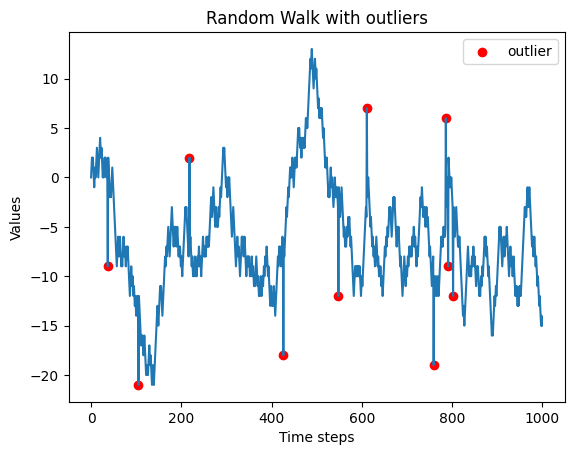

In [47]:
rw, outlier_ind = random_walk_with_outliers(0, 1000, 0.01)
plt.plot(np.arange(len(rw)), rw)
plt.scatter(outlier_ind, rw[outlier_ind], c='r', label='outlier')
plt.title('Random Walk with outliers')
plt.xlabel('Time steps')
plt.ylabel('Values')
plt.legend();

## Creamos la función para evaluar la detección de los outliers (comparando los atípicos reales vs los atípicos detectados)

In [48]:
def evaluate_detection(series, true_indices, detected_indices):
    
    # calculate metrics
    tp = list(set(detected_outliers).intersection(set(true_indices)))
    fp = list(set(detected_outliers).difference(set(true_indices)))
    fn = list(set(true_indices).difference(set(detected_outliers)))
    perc_detected = 100 * len(tp) / len(true_indices)
    
    # create the plot
    fix, ax = plt.subplots(2, 1,figsize=(10,10))
    
    ax[0].plot(np.arange(len(series)), series);
    ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier')
    ax[0].set_title('Original series')
    ax[0].legend()
    
    ax[1].plot(np.arange(len(series)), series);
    ax[1].scatter(tp, series[tp], c='g', label='true positive')
    ax[1].scatter(fp, series[fp], c='r', label='false positive')
    ax[1].scatter(fn, series[fn], c='k', label='false negative')
    ax[1].set_title('Algorithm results')
    ax[1].legend()
    
    # print out summary
    print('-' * 25 + ' Summary ' + '-' * 25)
    print(f'Outliers in the series: {len(true_indices)}')
    print(f'Identified outliers: {len(detected_indices)}')
    print(f'Correctly detected outliers: {len(tp)} ({perc_detected:.2f}% of all outliers).')
    print('-' * 59)
    
    return tp, fp, fn


## Hampel Filter
Basado en la idea del paquete "pracma" de R

In [49]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [50]:
res, detected_outliers = hampel_filter_forloop(rw, 10, 3)

In [51]:
detected_outliers

[20, 37, 105, 218, 330, 426, 548, 611, 721, 759, 786, 791, 802]

## Evaluar el resultado


------------------------- Summary -------------------------
Outliers in the series: 10
Identified outliers: 13
Correctly detected outliers: 10 (100.00% of all outliers).
-----------------------------------------------------------


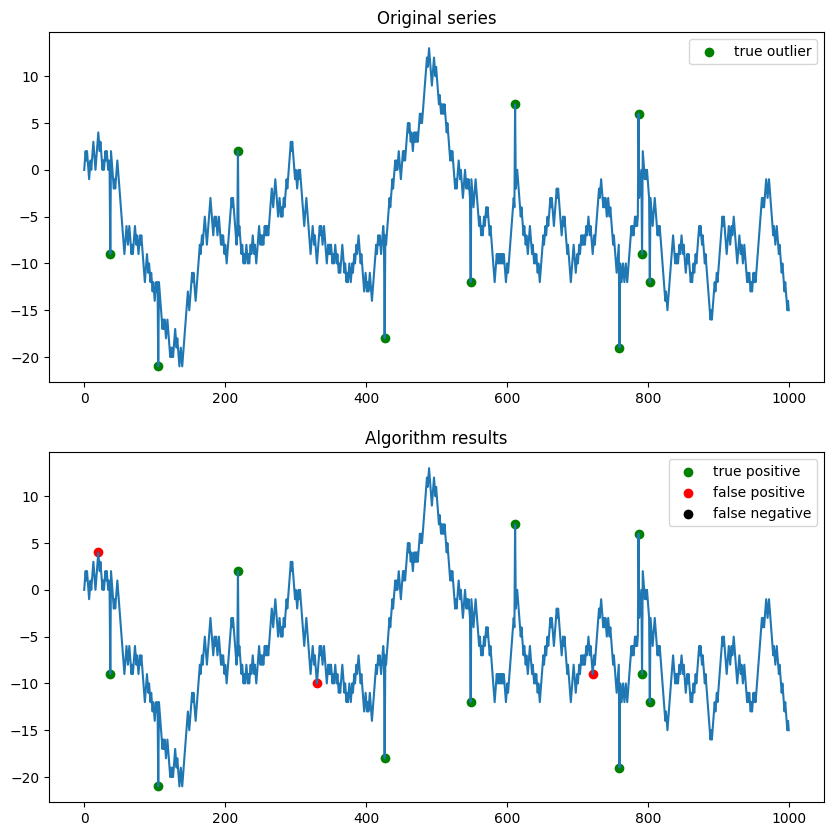

In [52]:
tp, fp, fn = evaluate_detection(rw, outlier_ind, detected_outliers)


## Serie de tiempo transformada después de eliminar los atípicos

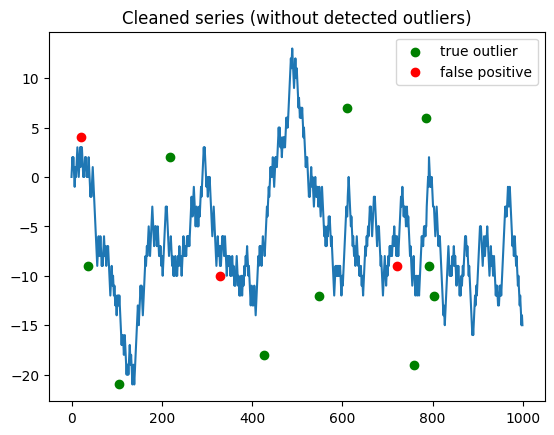

In [53]:
plt.plot(np.arange(len(res)), res);
plt.scatter(outlier_ind, rw[outlier_ind], c='g', label='true outlier')
plt.scatter(fp, rw[fp], c='r', label='false positive')
plt.title('Cleaned series (without detected outliers)')
plt.legend();